In [1]:
import time, datetime, os, random
str_format = '%Y%m%d%H%M%S'
readable_format = '%Y/%m/%d %H:%M:%S'

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torchvision import datasets, transforms
import torch.nn.functional as F



data_dir = './data/'
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
RANDOM_SEED=123


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)
    
    
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_deterministic
set_all_seeds(RANDOM_SEED)


In [2]:
#### Import and Initialize Data
print(f'Using {device} device')

train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

training_data = datasets.MNIST( root ='./data',
                            train = True,
                            download = True,
                            transform = train_transform)

validation_data = datasets.MNIST( root ='./data',
                            train = True,
                            download = True,
                            transform = test_transform)



testing_data = datasets.MNIST( root ='./data',
                            train = True,
                            download = False,
                            transform = test_transform)


train_data_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=256, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=256, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(dataset=testing_data, batch_size=256, shuffle=True)

Using cuda device


In [3]:
def default_func(X,Y):
    label = X
    return X,label


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]



##Maybe this should be a parent class that all models inheret from
class VAE(nn.Module):
    def __init__(self, name='autoencoder', epoch = 0):
        super().__init__()

        self.name = name
        self.epoch  = epoch
        

        self.encoder = nn.Sequential(
                                      nn.Conv2d(1, 32, stride=(1,1), kernel_size=(3,3), padding = 1),
                                      nn.LeakyReLU(0.01),
                                      nn.Conv2d(32,64, stride=(2,2), kernel_size=(3,3), padding = 1),
                                      nn.LeakyReLU(0.01),
                                      nn.Conv2d(64,64, stride=(2,2), kernel_size=(3,3), padding = 1),
                                      nn.LeakyReLU(0.01),
                                      nn.Flatten()
                                     )
        
        self.z_mu = nn.Linear(3136,2)
        self.z_log_var = nn.Linear(3136,2)

        self.decoder = nn.Sequential(
                                      nn.Linear(2,3136),
                                      Reshape(-1, 64, 7, 7),
                                      nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                                      nn.LeakyReLU(0.01),
                                      nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                                      nn.LeakyReLU(0.01),
                                      nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                                      nn.LeakyReLU(0.01),
                                      nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                                      Trim(),  # 1x29x29 -> 1x28x28
                                      nn.Sigmoid()
                                    )

    
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mu, z_log_var = self.z_mu(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mu, z_log_var)
        
        return encoded
    
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        
        return z
        
        
    def forward(self, x):
        x = self.encoder(x)
        z_mu, z_log_var = self.z_mu(x), self.z_log_var(x)
        z = self.reparameterize(z_mu, z_log_var)
        x_prime = self.decoder(z)
        return z, z_mu, z_log_var, x_prime


In [4]:
#### Load Model

set_all_seeds(RANDOM_SEED)

model = VAE(name = 'VAE').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr =.0005)


In [5]:
# Train

def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [6]:
#### Training Loop

num_epochs = 50

# results = model.train_model(train_data_loader, test_data_loader, num_epochs)

log_dict = train_vae_v1(num_epochs=num_epochs, model=model, 
                        optimizer=optimizer, device=device, 
                        train_loader=train_data_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)


# ts = datetime.datetime.now().strftime(str_format)
# filepath = f'{data_dir}{ts}-{model.name}_checkpoint.pth'

# model.save_model(optimizer=optimizer, path=filepath)

Epoch: 001/050 | Batch 0000/0235 | Loss: 149.2911
Epoch: 001/050 | Batch 0050/0235 | Loss: 55.8607
Epoch: 001/050 | Batch 0100/0235 | Loss: 52.9964
Epoch: 001/050 | Batch 0150/0235 | Loss: 49.0325
Epoch: 001/050 | Batch 0200/0235 | Loss: 45.7142
Time elapsed: 0.13 min
Epoch: 002/050 | Batch 0000/0235 | Loss: 44.5187
Epoch: 002/050 | Batch 0050/0235 | Loss: 47.2619
Epoch: 002/050 | Batch 0100/0235 | Loss: 45.0662
Epoch: 002/050 | Batch 0150/0235 | Loss: 44.2515
Epoch: 002/050 | Batch 0200/0235 | Loss: 42.5536
Time elapsed: 0.25 min
Epoch: 003/050 | Batch 0000/0235 | Loss: 42.9190
Epoch: 003/050 | Batch 0050/0235 | Loss: 43.2075
Epoch: 003/050 | Batch 0100/0235 | Loss: 41.2362
Epoch: 003/050 | Batch 0150/0235 | Loss: 41.0547
Epoch: 003/050 | Batch 0200/0235 | Loss: 41.5780
Time elapsed: 0.36 min
Epoch: 004/050 | Batch 0000/0235 | Loss: 40.6416
Epoch: 004/050 | Batch 0050/0235 | Loss: 41.2578
Epoch: 004/050 | Batch 0100/0235 | Loss: 41.9113
Epoch: 004/050 | Batch 0150/0235 | Loss: 40.4044

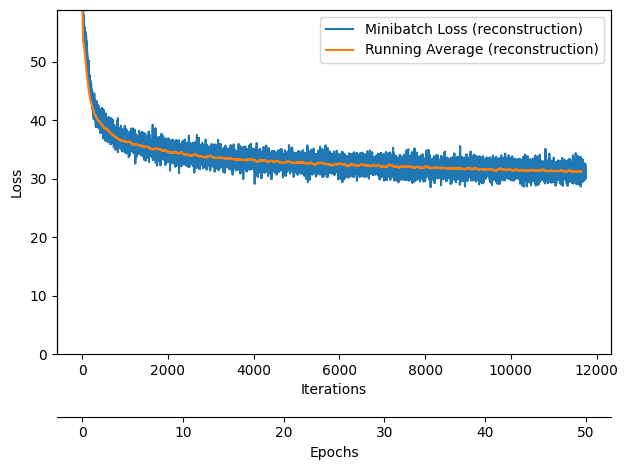

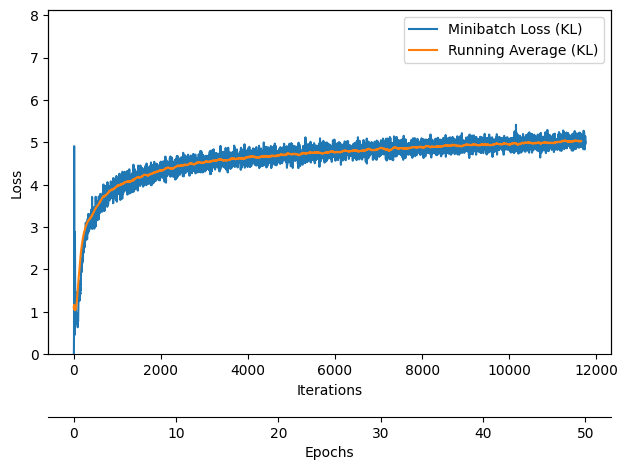

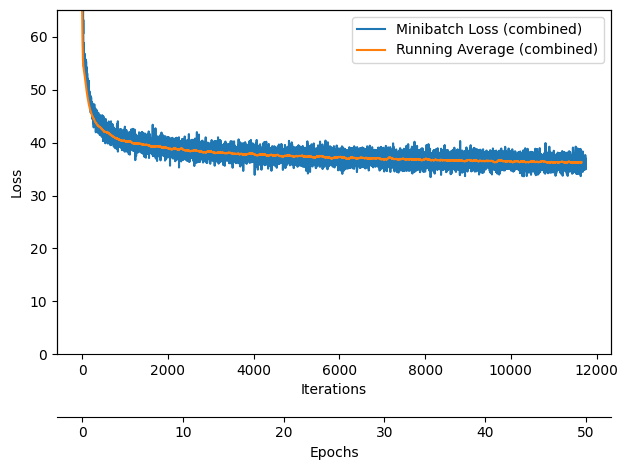

In [7]:
### Plot Results



def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()



plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], num_epochs, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], num_epochs, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], num_epochs, custom_label=" (combined)")
plt.show()

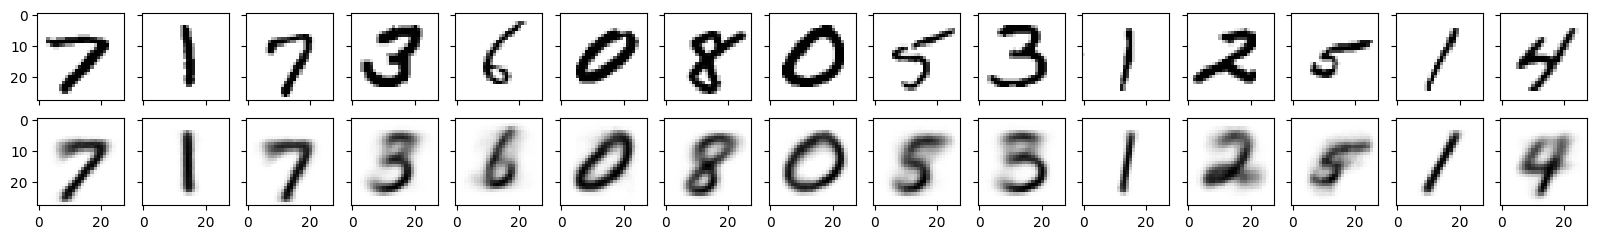

In [8]:
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
        



plot_generated_images(data_loader=train_data_loader, model=model, device=device, modeltype='VAE')   

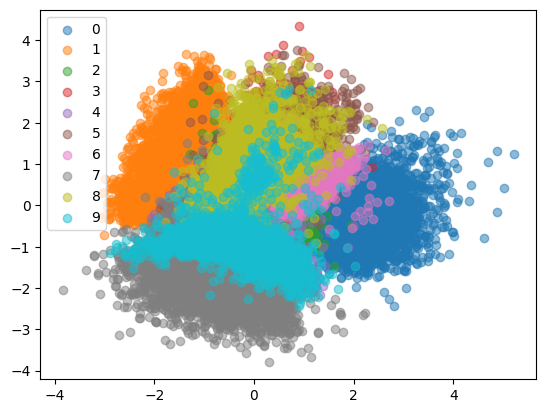

In [9]:
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)
            
            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()



plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_data_loader,
    encoding_fn=model.encoding_fn, 
    device=device)

plt.legend()
plt.show()

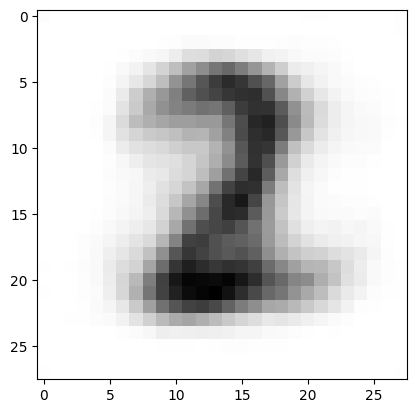

In [10]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to(device))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

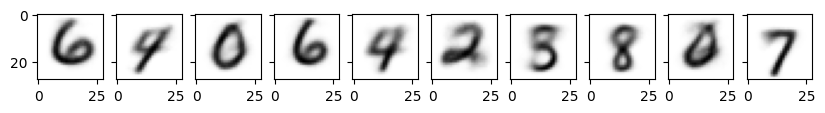

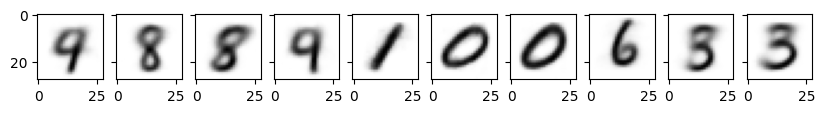

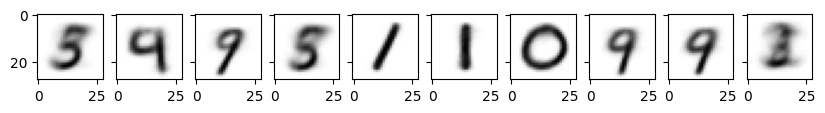

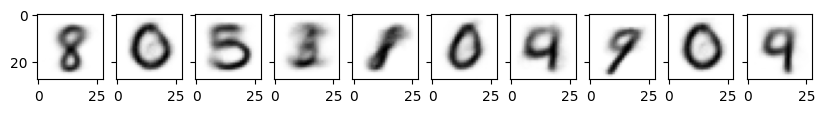

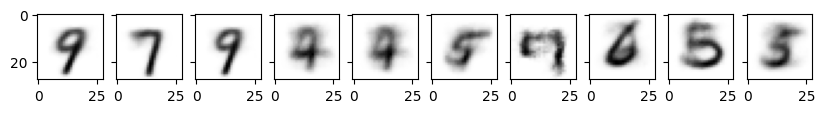

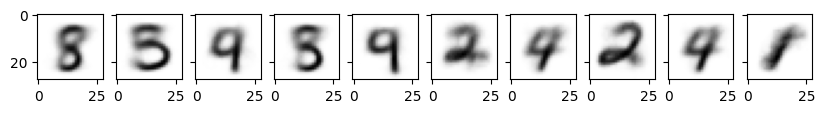

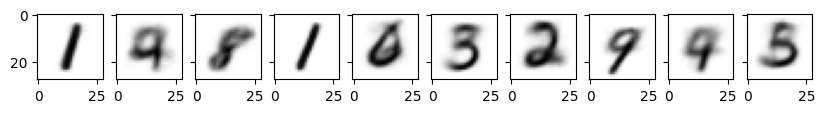

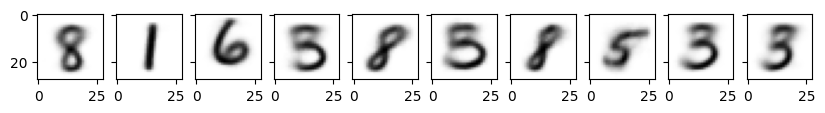

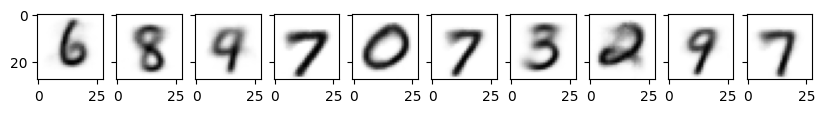

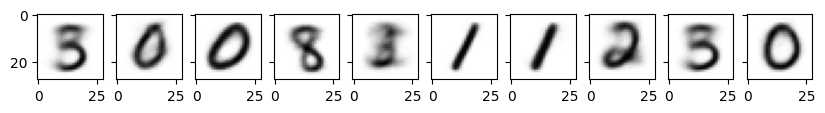

In [12]:
def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################    

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 
                
                



for i in range(10):
    plot_images_sampled_from_vae(model=model, device=device, latent_size=2)
    plt.show()